In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('aug_train.csv')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
df.select_dtypes('object').nunique()

ordinal_cols = ['city', 'experience']
onehot_cols = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type', 'last_new_job']
num_cols = ['enrollee_id', 'city_development_index', 'training_hours']
df.dtypes


enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [5]:
df.isnull().any()

enrollee_id               False
city                      False
city_development_index    False
gender                     True
relevent_experience       False
enrolled_university        True
education_level            True
major_discipline           True
experience                 True
company_size               True
company_type               True
last_new_job               True
training_hours            False
target                    False
dtype: bool

In [12]:
X = df.drop('target', axis=1)
y = pd.DataFrame(df['target'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
sample_row = X.iloc[0,:].to_dict()

In [7]:

num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

onehot_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessing = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('ordinal_pipeline', ordinal_pipeline, ordinal_cols),
    ('onehot_pipeline', onehot_pipeline, onehot_cols)
])

model = XGBClassifier()

pipeline = Pipeline(steps=[
    ('transformer', preprocessing),
    ('model', model)
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)


print(f'accuracy: {accuracy_score(y_valid, preds)}')


accuracy: 0.7670494084899095


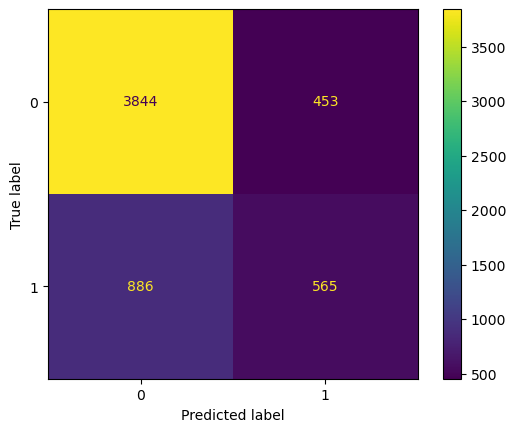

In [8]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

In [9]:
import pickle
with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [13]:
from pydantic import BaseModel, ValidationError

class Job(BaseModel):
    enrollee_id: int
    city: object
    city_development_index: object
    gender: object
    relevent_experience: object
    enrolled_university: object
    education_level: object
    major_discipline: object
    experience: object
    company_size: object
    company_type: object
    last_new_job: object
    training_hours: object

with open('pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

print(sample_row)
job = Job(**sample_row)
inputs = pd.DataFrame([job.model_dump()])
pred = loaded_pipeline.predict(inputs)[0]
pred

{'enrollee_id': 8949, 'city': 'city_103', 'city_development_index': 0.92, 'gender': 'Male', 'relevent_experience': 'Has relevent experience', 'enrolled_university': 'no_enrollment', 'education_level': 'Graduate', 'major_discipline': 'STEM', 'experience': '>20', 'company_size': nan, 'company_type': nan, 'last_new_job': '1', 'training_hours': 36}


1

In [11]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        job = Job(**request.json)
        inputs = pd.DataFrame([job.model_dump()])
        pred = loaded_pipeline.predict(inputs)[0]
        response = {
            'prediction': int(pred)
        }
        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__=='__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
